In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.7 MB/s eta 0:00:00


In [2]:
comments = pd.read_csv('comments.csv');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
comments

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,review_comment_message,review_score
0,3,Recebi bem antes do prazo estipulado.,5
1,4,Parabéns lojas lannister adorei comprar pela I...,5
2,9,aparelho eficiente. no site a marca do aparelh...,4
3,12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
4,15,"Vendedor confiável, produto ok e entrega antes...",5
...,...,...,...
40972,99205,para este produto recebi de acordo com a compr...,4
40973,99208,Entregou dentro do prazo. O produto chegou em ...,5
40974,99215,"O produto não foi enviado com NF, não existe v...",3
40975,99221,"Excelente mochila, entrega super rápida. Super...",5


In [4]:
def preprocess_text(text):
    stop_words = set(stopwords.words('portuguese'))
    stop_words.update(('comprei', 'recebi', 'produtos', 'produto', 'compra'))
    stemmer = SnowballStemmer('portuguese')
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

comments['processed'] = comments['review_comment_message'].apply(preprocess_text)
comments_one = comments[comments['review_score']==1]['processed']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(comments_one)

corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)
id2word = Dictionary.from_corpus(corpus, id2word=dict(enumerate(vectorizer.get_feature_names_out())))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
lda_model = LdaModel(corpus, num_topics=5, id2word=id2word, passes=15)


topics = lda_model.print_topics(num_words=5)
formatted_topics = []

for topic_num, topic in topics:
    words = topic.split(' + ')
    words_only = [word.split('*')[1].replace('"', '').strip() for word in words]
    formatted_topics.append(f"Topic {topic_num}: {', '.join(words_only)}")

comments['top_5_topics'] = [formatted_topics] * len(comments)

comments.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,review_comment_message,review_score,processed,top_5_topics
0,3,Recebi bem antes do prazo estipulado.,5,bem antes prazo estipulado,"[Topic 0: qualidade, diferente, veio, péssima,..."
1,4,Parabéns lojas lannister adorei comprar pela I...,5,parabéns lojas lannister adorei comprar intern...,"[Topic 0: qualidade, diferente, veio, péssima,..."
2,9,aparelho eficiente. no site a marca do aparelh...,4,aparelho eficiente site marca aparelho impress...,"[Topic 0: qualidade, diferente, veio, péssima,..."
3,12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,pouco travando valor ta boa,"[Topic 0: qualidade, diferente, veio, péssima,..."
4,15,"Vendedor confiável, produto ok e entrega antes...",5,vendedor confiável ok entrega antes prazo,"[Topic 0: qualidade, diferente, veio, péssima,..."


In [9]:
from googletrans import Translator
translator = Translator()
unique_keywords = []
for topic in formatted_topics:
    keywords = topic.split(": ")[1].split(", ")
    unique_keywords.extend(keywords)

unique_keywords = list(set(unique_keywords))
translated_keywords = {}
for keyword in unique_keywords:
    translated_keywords[keyword] = translator.translate(keyword, dest='en').text
def translate_topics(row):
    translated_topic = []
    for topic in row['top_5_topics']:
        topic_num, keywords_str = topic.split(": ", 1)
        keywords = keywords_str.split(", ")
        translated_keywords_topic = [translated_keywords.get(keyword, keyword) for keyword in keywords]
        translated_topic.append(f"{topic_num}: {', '.join(translated_keywords_topic)}")
    return translated_topic

comments['translated_top_5_topics'] = comments.apply(translate_topics, axis=1)

comments.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/httpx/_config.py:156: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  context = ssl.SSLContext(ssl.PROTOCOL_TLS)
/usr/local/lib/python3.10/dist-packages/httpx/_config.py:159: DeprecationWarning: ssl.OP_NO_SSL*/ssl.OP_NO_TLS* options are deprecated
  context.options |= ssl.OP_NO_TLSv1
/usr/local/lib/python3.10/dist-packages/httpx/_config.py:160: DeprecationWarning: ssl.OP_NO_SSL*/ssl.OP_NO_TLS* options are deprecated
  context.options |= ssl.OP_NO_TLSv1_1


,Unnamed: 0,review_comment_message,review_score,processed,top_5_topics,translated_top_5_topics
0,3,Recebi bem antes do prazo estipulado.,5,bem antes prazo estipulado,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
1,4,Parabéns lojas lannister adorei comprar pela I...,5,parabéns lojas lannister adorei comprar intern...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
2,9,aparelho eficiente. no site a marca do aparelh...,4,aparelho eficiente site marca aparelho impress...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
3,12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,pouco travando valor ta boa,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
4,15,"Vendedor confiável, produto ok e entrega antes...",5,vendedor confiável ok entrega antes prazo,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."


In [17]:
comments.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,review_comment_message,review_score,processed,top_5_topics,translated_top_5_topics
40972,99205,para este produto recebi de acordo com a compr...,4,acordo realizada,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
40973,99208,Entregou dentro do prazo. O produto chegou em ...,5,entregou dentro prazo chegou condições perfeit...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
40974,99215,"O produto não foi enviado com NF, não existe v...",3,enviado nf existe venda nf certeza fico aguard...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
40975,99221,"Excelente mochila, entrega super rápida. Super...",5,excelente mochila entrega super rápida super r...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
40976,99223,"meu produto chegou e ja tenho que devolver, po...",1,chegou ja devolver pois defeito segurar carga,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."


In [11]:
pip install googletrans==4.0.0-rc1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=9e530c84861da281408d3f9dbd0ccd9dc87954279b33f22ee6269123f24bc8f6
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:


In [11]:
comments

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,review_comment_message,review_score,processed,top_5_topics,translated_top_5_topics
0,3,Recebi bem antes do prazo estipulado.,5,bem antes prazo estipulado,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
1,4,Parabéns lojas lannister adorei comprar pela I...,5,parabéns lojas lannister adorei comprar intern...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
2,9,aparelho eficiente. no site a marca do aparelh...,4,aparelho eficiente site marca aparelho impress...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
3,12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,pouco travando valor ta boa,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
4,15,"Vendedor confiável, produto ok e entrega antes...",5,vendedor confiável ok entrega antes prazo,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
...,...,...,...,...,...,...
40972,99205,para este produto recebi de acordo com a compr...,4,acordo realizada,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
40973,99208,Entregou dentro do prazo. O produto chegou em ...,5,entregou dentro prazo chegou condições perfeit...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
40974,99215,"O produto não foi enviado com NF, não existe v...",3,enviado nf existe venda nf certeza fico aguard...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."
40975,99221,"Excelente mochila, entrega super rápida. Super...",5,excelente mochila entrega super rápida super r...,"[Topic 0: qualidade, diferente, veio, péssima,...","[Topic 0: quality, different, he came, bad, I ..."


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


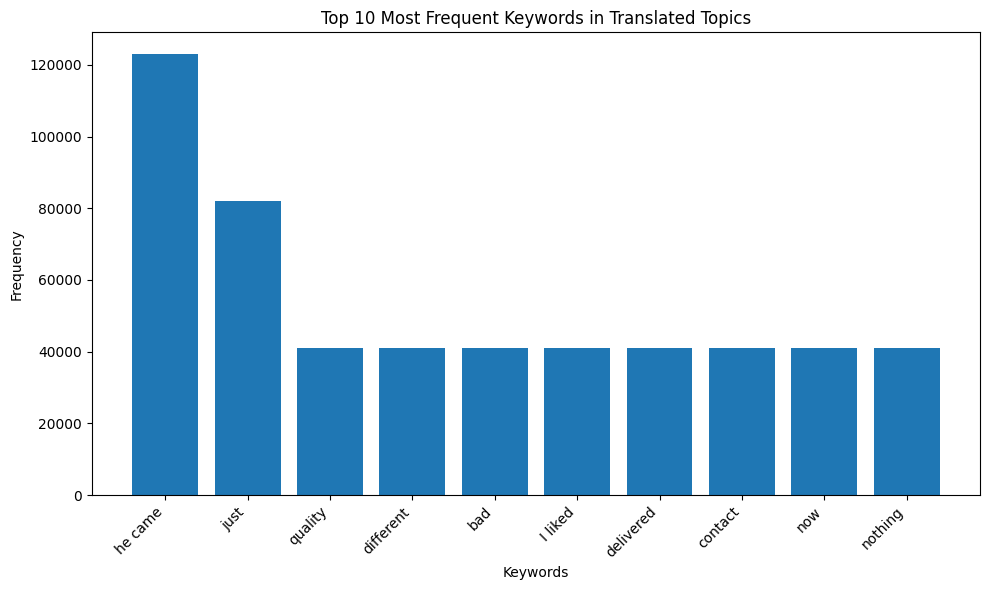

In [16]:

import matplotlib.pyplot as plt
from collections import Counter

all_keywords = []
for topics_list in comments['translated_top_5_topics']:
    for topic in topics_list:
        keywords = topic.split(": ")[1].split(", ")
        all_keywords.extend(keywords)

keyword_counts = Counter(all_keywords)
top_10_keywords = keyword_counts.most_common(10)
keywords = [keyword for keyword, count in top_10_keywords]
counts = [count for keyword, count in top_10_keywords]

plt.figure(figsize=(10, 6))
plt.bar(keywords, counts)
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.title("Top 10 Most Frequent Keywords in Translated Topics")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


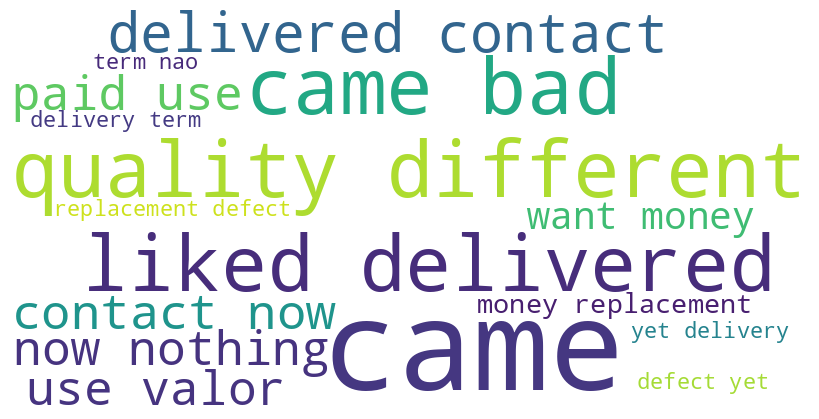

In [15]:

from wordcloud import WordCloud

text = " ".join(all_keywords)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()